# Collaborative filtering

[video](https://www.youtube.com/watch?v=9YK6AnqpuEA),
[doc](https://docs.fast.ai/collab.html),
[notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson4-collab.ipynb)

- **Information** about **who** and **what**.
- You usually have 3 columns. Ex. user id, movie id, rating.
- You also can have more columns like review or timestamp.
- The objective is to complete the information. Ex get probable ratings.

#### Ways of representation

- **3 columns**, with *who-what-value* rows. Common for data storage.
- **2d matrix**, with all *who-what* combinations. Common for representation.

> The cold start problem is when you have a new user, you don't known nothing about him. Solution
> - Obtain some feedback about what does he like (Netflix).
> - Start with a common probable sugestion (Amazon).



In [1]:
from fastai.collab import *
from fastai.tabular import *

# Temporal fix to a pandas bug
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

## Mini-example

In [2]:
path    = untar_data(URLs.ML_SAMPLE)
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


In [9]:
################## Get databunch
data    = CollabDataBunch.from_df(ratings, seed=42)
y_range = [0,5.5]

################# Learn
learn = collab_learner(data, n_factors=50, y_range=y_range)
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss
1,1.633071,0.967251
2,0.856595,0.678166
3,0.656795,0.669824


## Whats happening under the hood
1. Give each **who** a random 5-size vector. (user embedding)
2. Give each **what** a random 5-size vector. (movie embedding)
3. The predicted **value** will be the multiplication of those 2 vectors plus the biases.
4. Apply gradient descent to optimize values to match ground-truth values.

![img](https://cdn-images-1.medium.com/max/1540/1*3f1x1X5POBvjqVksN3oV0A.png)

As you may have guessed, the model is a 1, 2 or 3 fc layers net.
1. The first layer is the embeding matrix. The input is a one-hot vector and the output is the user/movie embedding.
2. Then we concatenate the user embedding and the movie embedding into one vector.
3. One trick is we know the output ranking range is between 0 and 5. So we multiply the output sigmoid by ((5-0)+0) = 5.


![img](https://www.researchgate.net/profile/Shuai_Zhang98/publication/318671349/figure/fig20/AS:660916903354368@1534586277549/Illustration-of-a-Neural-Collaborative-Filtering-b-CCCFNet-c-Wide-Deep.png)

## Dataset: Movielens 100k
Let's try with the full Movielens 100k data dataset

In [2]:
path = Config.data_path()/'ml-100k'
path

WindowsPath('C:/Users/Javi/.fastai/data/ml-100k')

In [4]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=['userId','movieId','rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
len(ratings)

100000

In [5]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=['movieId', 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
len(movies)

1682

In [9]:
rating_movie = ratings.merge(movies[['movieId', 'title']])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


## Create databunch

In [17]:
data = CollabDataBunch.from_df(rating_movie, seed=42, pct_val=0.1, item_name='title')
#data.show_batch()

## Train

In [18]:
y_range = [0,5.5] # A bit wider from [0.5, 5] that is the real range
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


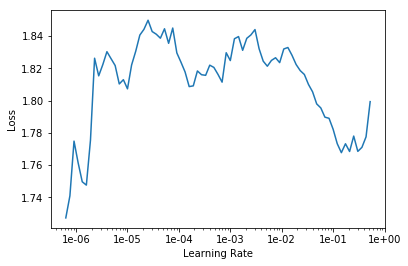

In [21]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [22]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss
1,0.932731,0.946472
2,0.856689,0.887424
3,0.762599,0.837933
4,0.645613,0.817885
5,0.526881,0.818705


In [23]:
learn.save('dotprod')

## Test

In [24]:
learn.load('dotprod');
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

### Show top best/worst movies by looking the movies biases

In [26]:
g = rating_movie.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

In [27]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [29]:
mean_ratings = rating_movie.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [31]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3498),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3482),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.3232), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2972), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2746), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2556), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2486), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2404), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2378), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2357), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2121), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2109), 'Lawnmower Man, The (1992)', 2.4461538461538463),
 (tensor(-0.2079), "Stephen King's The Langoliers (1995)", 2.413793103448276),
 (tensor(-0.2062), 'Leave It to Beaver (1997)', 1.840

In [32]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5961), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5954), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5865), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5678), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5373), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5303), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5108), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5038), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4828), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4828), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4811), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4785), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4760), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4680), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4649), 'Godfather, The (1972)', 4.283292978208232)]

### Show top best/worst movies by looking the movies weights

In [34]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [35]:
############################# Fast.ai adds pcs() method to torch tensors!!!!!
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [ ]:
fac0,fac1,fac2 = movie_pca.t()

### See component 1

In [36]:
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [37]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1437), 'Wrong Trousers, The (1993)'),
 (tensor(1.0728), 'Casablanca (1942)'),
 (tensor(1.0688), 'Close Shave, A (1995)'),
 (tensor(0.9902), 'Chinatown (1974)'),
 (tensor(0.9847), 'When We Were Kings (1996)'),
 (tensor(0.9736), 'North by Northwest (1959)'),
 (tensor(0.9505),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(0.9488), 'Apocalypse Now (1979)'),
 (tensor(0.9385), '12 Angry Men (1957)'),
 (tensor(0.9378), 'Lawrence of Arabia (1962)')]

In [38]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2821), "McHale's Navy (1997)"),
 (tensor(-1.2814), 'Home Alone 3 (1997)'),
 (tensor(-1.2248), 'Leave It to Beaver (1997)'),
 (tensor(-1.2033), 'Jungle2Jungle (1997)'),
 (tensor(-1.1901), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.1783), 'Flipper (1996)'),
 (tensor(-1.1381), 'Congo (1995)'),
 (tensor(-1.1195), 'Grease 2 (1982)'),
 (tensor(-1.1027), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.0771), 'Bio-Dome (1996)')]

### See component 2

In [40]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [41]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1952), 'Braveheart (1995)'),
 (tensor(1.0656), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.9823), 'Titanic (1997)'),
 (tensor(0.9103), "It's a Wonderful Life (1946)"),
 (tensor(0.8871), 'Forrest Gump (1994)'),
 (tensor(0.8765), "Mr. Holland's Opus (1995)"),
 (tensor(0.8759), 'Pretty Woman (1990)'),
 (tensor(0.8711), 'Independence Day (ID4) (1996)'),
 (tensor(0.8602), 'Back to the Future (1985)'),
 (tensor(0.8425), 'American President, The (1995)')]

In [42]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8753), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.7748), 'Keys to Tulsa (1997)'),
 (tensor(-0.7692), 'Trainspotting (1996)'),
 (tensor(-0.7492), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(-0.7345), 'Beavis and Butt-head Do America (1996)'),
 (tensor(-0.7265), 'Stupids, The (1996)'),
 (tensor(-0.7222), 'Very Brady Sequel, A (1996)'),
 (tensor(-0.7118), 'Dead Man (1995)'),
 (tensor(-0.7115), 'Serial Mom (1994)'),
 (tensor(-0.7104), 'Clockwork Orange, A (1971)')]

### See component 1 along with component 3

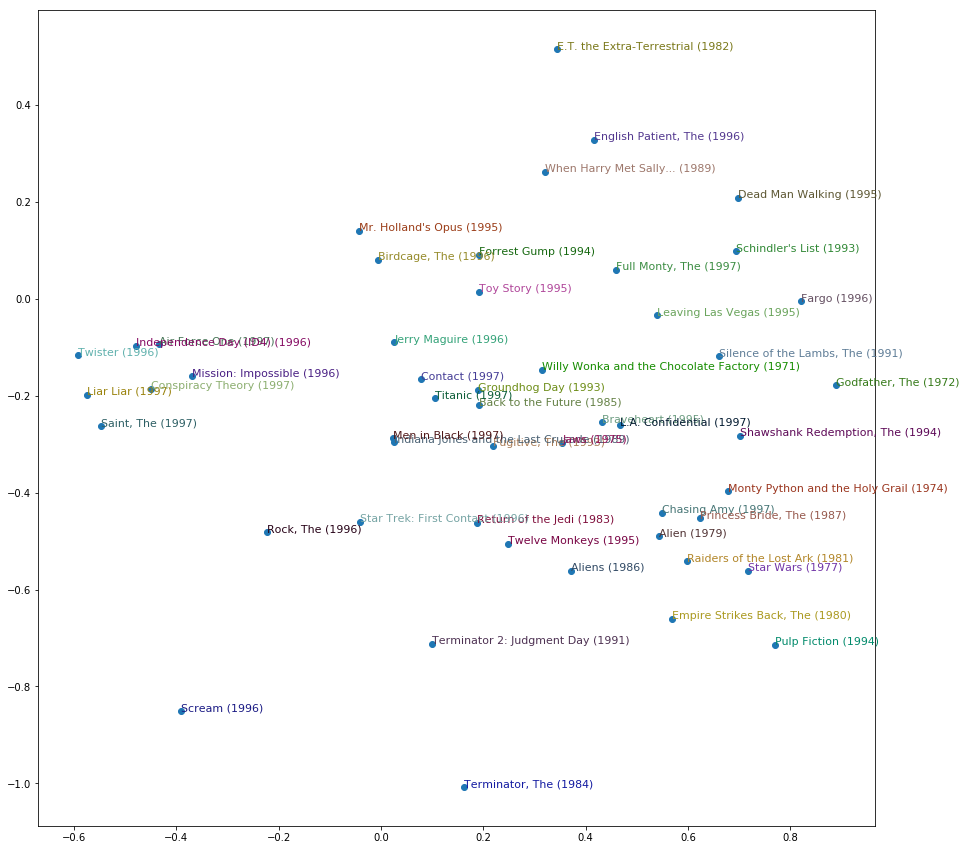

In [39]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()